In [1]:
import networkit as nk
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.legend as ld
import plotly.express as plx
import powerlaw
import numpy as np
import json
import pandas as pd
import math
import random
from progress.bar import Bar
import threading

In [2]:
def GenGraphFromSubset(graph: nx.graph.Graph, community: list[int]) -> nx.Graph:
        subGraph = nx.Graph()
        subGraph.add_nodes_from(community)
        for node in community:
            for target in community:
                if graph.has_edge(node,target):
                    subGraph.add_edge(node,target)
                    pass
                pass
            pass
        return subGraph

def LoadFeatures(graph : nx.Graph, jsonFile : str):
    file = open(jsonFile,"r")
    jsonValues = json.load(file)
    trValues= {}
    for i in range(len(jsonValues)):
        trValues[i] = [] 
        for value in jsonValues[str(i)]:
            trValues[i].append(value)  
            pass
        pass
    nx.set_node_attributes(graph,trValues)
    pass

def LoadTarget(graph: nx.graph.Graph,targetFile):
    tg = pd.read_csv(targetFile)
    ml_target = {}
    usernames= {}
    for i in range(graph.number_of_nodes()):
        ml_target[i] = tg["ml_target"][i]
        usernames[i] = tg["name"][i]
        pass
    nx.set_node_attributes(graph,ml_target,"ml_target")
    nx.set_node_attributes(graph,usernames,"username")
    pass

def PrintStat(array: list[int]):
    print("Mean: " + str(np.mean(array)))
    print("Max: " + str(np.max(array)))
    print("Min: " + str(np.min(array)))
    print("Variance: " + str(np.var(array)))
    pass

def ExtractDegreeNodes(nxgraph: nx.graph.Graph,degree : int) -> list[int]:
    nodes = []
    degrees = nxgraph.degree()
    for node in nxgraph:
        if degrees[node] == degree:
            nodes.append(node)
            pass
        pass
    return nodes






In [3]:

graph = nk.graphio.EdgeListReader(",",0).read("./musae_git_edges.csv")
nxgraph = nk.nxadapter.nk2nx(graph)
LoadTarget(nxgraph,"./musae_git_target.csv")

Basic Measure

In [7]:
L = nxgraph.number_of_edges()
N = nxgraph.number_of_nodes()
density = (2*L)/(N*(N-1))
L

289003

Degree

Mean: 15.331724137931035
Max: 9458
Min: 1
Variance: 6526.544335754138
Estimated density: 0.00040668782031170683


(array([3.7676e+04, 1.7000e+01, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 9.4670e+02, 1.8924e+03, 2.8381e+03, 3.7838e+03,
        4.7295e+03, 5.6752e+03, 6.6209e+03, 7.5666e+03, 8.5123e+03,
        9.4580e+03]),
 <BarContainer object of 10 artists>)

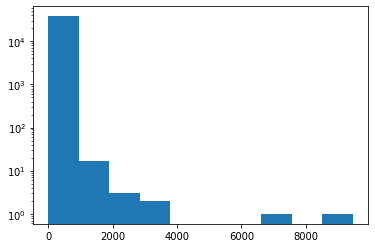

In [9]:
degrees = [degree[1] for degree in nxgraph.degree()]
PrintStat(degrees)
print("Estimated density: " + str(np.mean(degrees)/(N-1)))
plt.hist(degrees,log=True)

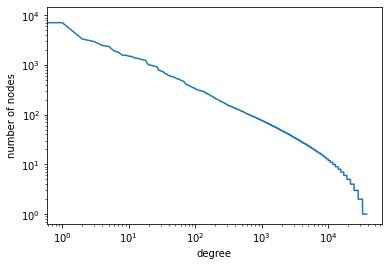

In [10]:
dd = sorted(nk.centrality.DegreeCentrality(graph).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [11]:
fit = powerlaw.Fit(dd)
fit.alpha

Calculating best minimal value for power law fit


2.573376136652345

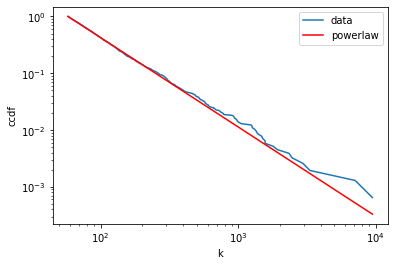

In [56]:
f = fit.plot_ccdf(label="data")
f.set_ylabel("ccdf")
f.set_xlabel("k")
fit.power_law.plot_ccdf(ax=f,color='r',label="powerlaw")
f.legend()


In [43]:
R, p = fit.distribution_compare("power_law","exponential",normalized_ratio=True)
print(R,p)
R, p = fit.distribution_compare("power_law","lognormal",normalized_ratio=True)
print(R,p)

5.2164112365353486 1.824229315101101e-07
-1.511893246219258 0.1305610224625886


In [4]:

def NKExtractDistances(graph: nk.graph.Graph, node : int, dict :dict[int,list[int]]) -> None:
    distances = []
    bfs = nk.distance.BFS(graph,node)
    bfs.run()
    for nodeT in nxgraph:
        if node != nodeT:
            distances.append(bfs.distance(nodeT))
        pass
    dict[node] = distances
    

globDistances = {}
for node in nxgraph:
    NKExtractDistances(graph,node,globDistances)
    pass


globDistances


In [8]:
clusteringCoeff = nx.clustering(nxgraph)


(array([18619.,  7831.,  4329.,  2989.,   874.,   817.,   721.,    35.,
           91.,  1394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

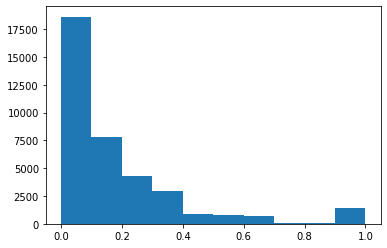

In [64]:
coeff = [val for val in clusteringCoeff.values()]

plx

In [30]:
nx.components.is_connected(nxgraph)

True

the graph is connected, so the whole graph is the giant connected component

Distances

In [92]:
bfs = nk.distance.BFS(graph,0)
bfs.run()
nkdistances = bfs.getDistances()

Mean: 3.6359151193633954
Max: 8.0
Min: 0.0
Variance: 0.35508145698625887


(array([1.0000e+00, 1.0000e+00, 3.1000e+01, 1.5812e+04, 1.9825e+04,
        1.9130e+03, 1.1000e+02, 6.0000e+00, 1.0000e+00]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <BarContainer object of 9 artists>)

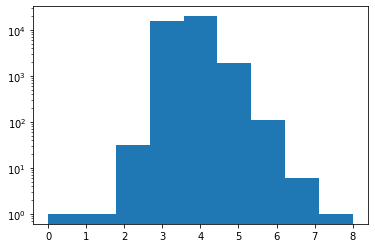

In [103]:
PrintStat(nkdistances)
plt.hist(nkdistances,log=True,bins=9)

In [36]:
diam = nk.distance.Diameter(graph,algo=1)
diam.run()
diam.getDiameter()

(11, 0)

Centralities

In [5]:
closeness = nk.centrality.Closeness(graph,False,False)
closeness.run()


Mean: 0.313667247491002
Max: 0.5230814058359118
Min: 0.1413885700998372
Variance: 0.001665102448375804


Text(0, 0.5, 'count')

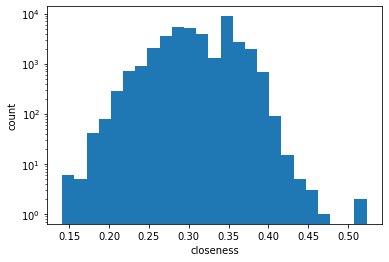

In [8]:
PrintStat(closeness.scores())
plt.hist(closeness.scores(),25, log=True)
plt.xlabel("closeness")
plt.ylabel("count")

Betwenness through estimation: The algorithm estimates the betweenness of all nodes, using weighting of the contributions to avoid biased estimation. The run() method takes O(m) time per sample, where m is the number of edges of the graph. There is no proven theoretical guarantee on the quality of the approximation. However, the algorithm was shown to perform well in practice. If a guarantee is required, use ApproxBetweenness. 

In [9]:
ebtw = nk.centrality.EstimateBetweenness(graph,100)
ebtw.run()

Mean: 83395.79999999993
Max: 352557349.97445965
Min: 0.0
Variance: 7211387358017.574
31890


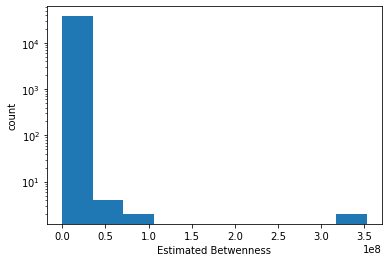

In [16]:
PrintStat(ebtw.scores())
plt.hist(ebtw.scores(),log=True)
plt.xlabel("Estimated Betwenness")
plt.ylabel("count")
max = np.max(ebtw.scores())
for i in range(nxgraph.number_of_nodes()):
    if ebtw.score(i) == max:
        print(i)
    pass

In [87]:

btw = nk.centrality.Betweenness(graph)
btw.run()

Mean: 84687.37310344815
Max: 383148252.27699816
Min: 0.0
Variance: 7679228493117.37


Mean: 84687.37310344815
Max: 383148252.276998
Min: 0.0
Variance: 7679228493117.379


(array([3.7638e+04, 3.3000e+01, 5.0000e+00, 8.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

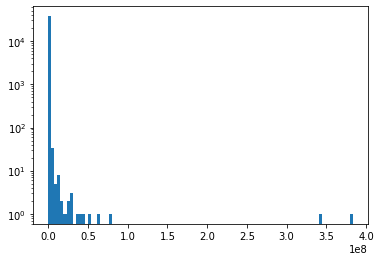

In [88]:
PrintStat(btw.scores())
plt.hist(btw.scores(),100,log=True)

Degree Correlation

In [4]:
knn= nx.average_neighbor_degree(nxgraph)
max_degree = np.max(nxgraph.degree())

In [24]:
degree_corr = []
expected_corr = []
assort_coeff= nx.assortativity.degree_assortativity_coefficient(nxgraph)
print(max_degree)
bar = Bar('Calculating',max=max_degree)
for k in range(1,max_degree,10):
    nodes = ExtractDegreeNodes(nxgraph,k)
    knns = []
    for node in nodes:
        knns.append(knn[node])
        pass
    if len(knns) > 0:
        degree_corr.append(np.mean(knns))
        pass
    else:
        degree_corr.append(0)
        pass
    expected_corr.append(k*assort_coeff*10)
    nodes=[]
    bar.next()
    print(k)
    pass
bar.finish()

37699
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991
1001
1011
1021
1031
1041
1051
1061
1071
1081
1091
1101
1111
1121
1131
1141
1151
1161
1171
1181
1191
1201
1211
1221
1231
1241
1251
1261
1271
1281
1291
1301
1311
1321
1331
1341
1351
1361
1371
1381
1391
1401
1411
1421
1431
1441
1451
1461
1471
1481
1491
1501
1511
1521
1531
1541
1551
1561
1571
1581
1591
1601
1611
1621
1631
1641
1651
1661
1671
1681
1691
1701
1711
1721
1731
1741
1751
1761
1771
1781
1791
1801
1811
1821
1831
1841
1851
1861
1871
1881
1891
1901
1911
1921
1931
1941
1951
1961
1971
1981
1991
2001
2011
2021
2031
2041
2051
2061
2071
2081
2091
2101
2111
2121
2131
2141
2151
2161
2171
2181
2191
2201


Text(0.5, 0, 'k')

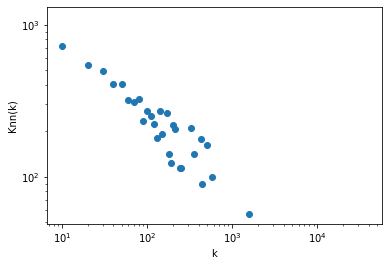

In [27]:
f = plt.scatter(np.arange(0,max_degree,10),degree_corr)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Knn(k)")
plt.xlabel("k")

In [36]:
cross_edges = 0
mlTargets = nx.get_node_attributes(nxgraph,"ml_target")
for node in nxgraph:
    for target in nxgraph:
        if nxgraph.has_edge(node,target):
            if mlTargets[node] != mlTargets[target]:
                cross_edges += 1
                pass
            pass
        pass
    pass
cross_edges

89392

In [48]:
ml = len([t for t in mlTargets.values() if t > 0])
web = len([t for t in mlTargets.values() if t == 0])
print("Number of ml: " + str(ml))
print("Number of web: "+ str(web))
print("Number of cross edges: " + str(cross_edges))
cross_edges < 2*ml*web

Number of ml: 9739
Number of web: 27961
Number of cross edges: 89392


True

In [16]:
nx.degree_assortativity_coefficient(nxgraph)

-0.07521713413904481

Chapter communities

In [45]:
louvainPart = nk.community.detectCommunities(graph,algo=nk.community.PLM(graph,True,maxIter=1000))
nk.community.EdgeCut(louvainPart).getQuality(louvainPart,graph)

Communities detected in 0.10186 [s]
solution properties:
-------------------  -------------
# communities            26
min community size        3
max community size     7770
avg. community size    1450
imbalance                 5.35862
edge cut             105199
edge cut (portion)        0.364007
modularity                0.456249
-------------------  -------------


105199.0

In [46]:
louvainComms = [[]]
for id in louvainPart.getSubsetIds():
    louvainComms.append([])
    pass

for node in nxgraph:
    louvainComms[louvainPart.subsetOf(node)].append(node)
    pass

louvainComms

[[0,
  4,
  44,
  52,
  67,
  69,
  71,
  72,
  89,
  96,
  129,
  145,
  168,
  223,
  233,
  251,
  284,
  305,
  325,
  337,
  399,
  404,
  422,
  436,
  501,
  502,
  541,
  551,
  591,
  606,
  607,
  632,
  647,
  660,
  668,
  714,
  728,
  771,
  796,
  805,
  810,
  821,
  823,
  833,
  843,
  881,
  887,
  896,
  922,
  943,
  944,
  950,
  988,
  992,
  1010,
  1132,
  1152,
  1167,
  1207,
  1212,
  1224,
  1238,
  1254,
  1260,
  1301,
  1315,
  1327,
  1339,
  1353,
  1380,
  1386,
  1387,
  1396,
  1399,
  1549,
  1559,
  1579,
  1618,
  1620,
  1645,
  1664,
  1704,
  1719,
  1789,
  1824,
  1829,
  1836,
  1869,
  1907,
  1912,
  1926,
  1943,
  1946,
  1959,
  1966,
  1975,
  1994,
  2049,
  2074,
  2076,
  2085,
  2087,
  2132,
  2158,
  2166,
  2171,
  2211,
  2221,
  2237,
  2239,
  2258,
  2322,
  2354,
  2356,
  2372,
  2374,
  2413,
  2422,
  2423,
  2444,
  2446,
  2494,
  2512,
  2530,
  2557,
  2587,
  2618,
  2716,
  2724,
  2742,
  2778,
  2780,
  2807,
  

/home/drfaust/.local/lib/python3.10/site-packages/networkit/viztasks.py:115: UserWarning: networkit.viztasks.drawCommunityGraph is deprecated, will be removed in future updates. Use networkit.vizbridges instead to draw graphs (needs additional plugins).
  warn("networkit.viztasks.drawCommunityGraph is deprecated, will be removed in future updates. Use networkit.vizbridges instead to draw graphs (needs additional plugins).")


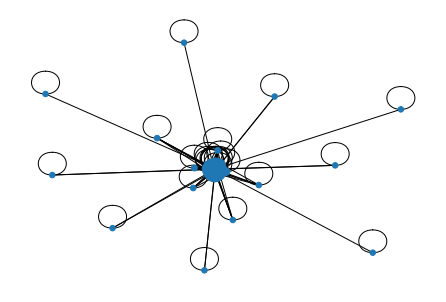

In [47]:
nk.viztasks.drawCommunityGraph(graph,louvainPart)

In [28]:
PrintStat(louvainPart.subsetSizes())

Mean: 1450.0
Max: 7883
Min: 3
Variance: 6215869.230769231


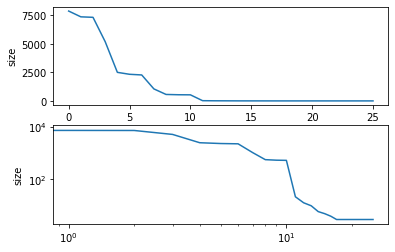

In [19]:
sizes = louvainPart.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

Calculating best minimal value for power law fit


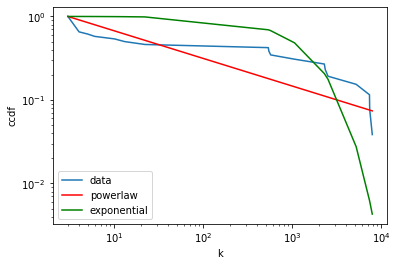

In [30]:
fit = powerlaw.Fit(louvainPart.subsetSizes())

f = fit.plot_ccdf(label="data")
f.set_ylabel("ccdf")
f.set_xlabel("k")
fit.power_law.plot_ccdf(ax=f,color='r',label="powerlaw")
fit.exponential.plot_ccdf(ax=f,color='g',label="exponential")
f.legend()


In [69]:
labelComms = nx.community.label_propagation_communities(nxgraph)
nx.algorithms.community.modularity(nxgraph,labelComms)

0.002918446982036539

In [49]:
def AnalyzeCommunityResults(nxgraph : nx.graph.Graph, communities):
    index = 0
    for community in communities:
        index += 1
        if len(community) >= nxgraph.size()/2:
            break
        commgraph = GenGraphFromSubset(nxgraph,community)
        print("################ comm id: " + str(index))
        print("Number of nodes: " + str(len(community)))
        mlTargets = nx.get_node_attributes(nxgraph,"ml_target")
        totalTarget = 0
        colormap = []
        for node in community:
            totalTarget += mlTargets[node]
            if mlTargets[node] == 1:
                    colormap.append('red')
                    pass
            else:
                colormap.append('blue')
                pass
        print("Number of MLTargets: " + str(totalTarget))
        if len(community) < 1000:
            pos = nx.circular_layout(commgraph)
            nx.draw(commgraph,pos,node_color=colormap)
            plt.show()
            pass
        pass
    pass


def PrintCommunity(nxgraph : nx.graph.Graph, community: list[int], layout):
    commgraph = GenGraphFromSubset(nxgraph,community)
    print("Number of nodes: " + str(len(community)))
    mlTargets = nx.get_node_attributes(nxgraph,"ml_target")
    totalTarget = 0
    colormap = []
    for node in community:
        totalTarget += mlTargets[node]
        if mlTargets[node] == 1:
                colormap.append('red')
                pass
        else:
            colormap.append('blue')
            pass
    print("Number of MLTargets: " + str(totalTarget))
    if len(community) < 1000:
        pos = layout(commgraph)
        nx.draw(commgraph,pos,node_color=colormap)
        plt.show()
        pass
    pass

################ comm id: 1
Number of nodes: 5196
Number of MLTargets: 902
################ comm id: 2
Number of nodes: 7333
Number of MLTargets: 1464
################ comm id: 3
Number of nodes: 2279
Number of MLTargets: 214
################ comm id: 4
Number of nodes: 535
Number of MLTargets: 164


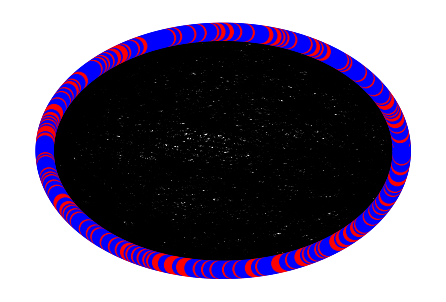

################ comm id: 5
Number of nodes: 569
Number of MLTargets: 72


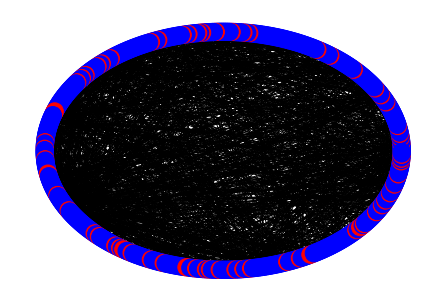

################ comm id: 6
Number of nodes: 7376
Number of MLTargets: 5542
################ comm id: 7
Number of nodes: 7883
Number of MLTargets: 421
################ comm id: 8
Number of nodes: 2337
Number of MLTargets: 437
################ comm id: 9
Number of nodes: 2507
Number of MLTargets: 150
################ comm id: 10
Number of nodes: 1055
Number of MLTargets: 244
################ comm id: 11
Number of nodes: 543
Number of MLTargets: 102


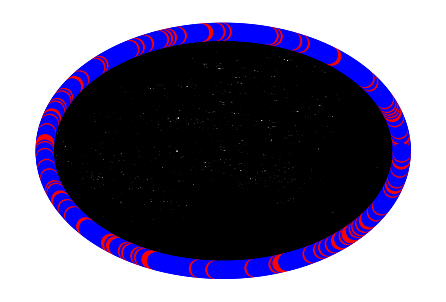

################ comm id: 12
Number of nodes: 6
Number of MLTargets: 6


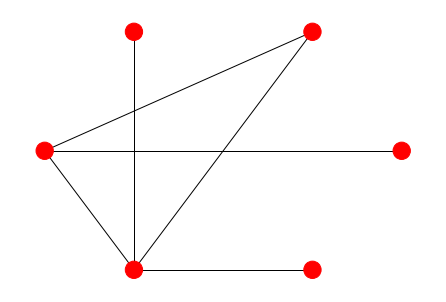

################ comm id: 13
Number of nodes: 3
Number of MLTargets: 0


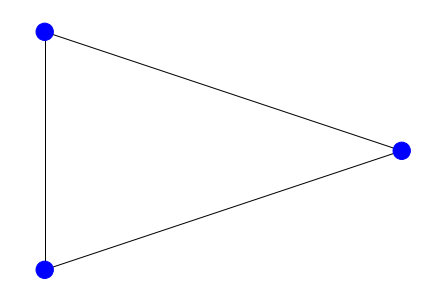

################ comm id: 14
Number of nodes: 22
Number of MLTargets: 14


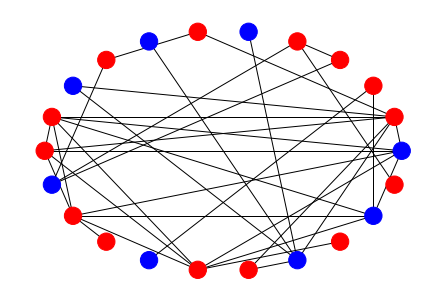

################ comm id: 15
Number of nodes: 13
Number of MLTargets: 0


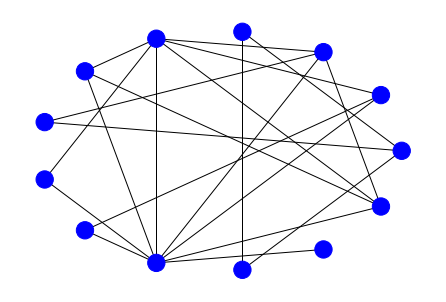

################ comm id: 16
Number of nodes: 3
Number of MLTargets: 0


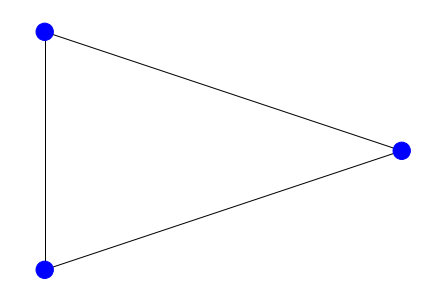

################ comm id: 17
Number of nodes: 3
Number of MLTargets: 0


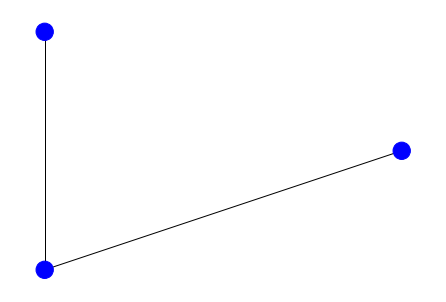

################ comm id: 18
Number of nodes: 5
Number of MLTargets: 0


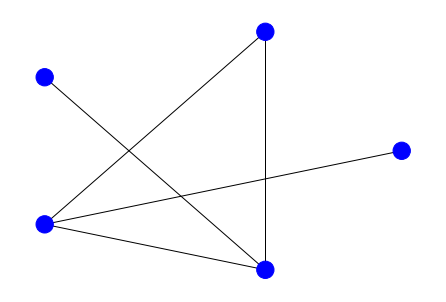

################ comm id: 19
Number of nodes: 10
Number of MLTargets: 2


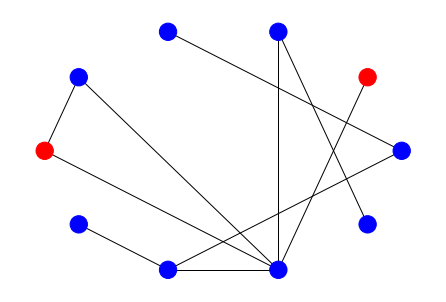

################ comm id: 20
Number of nodes: 3
Number of MLTargets: 0


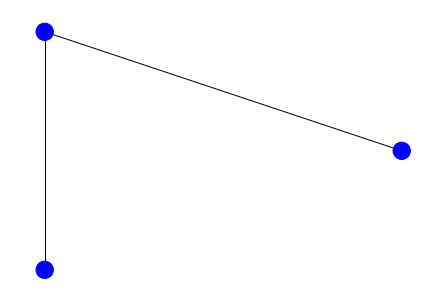

################ comm id: 21
Number of nodes: 3
Number of MLTargets: 2


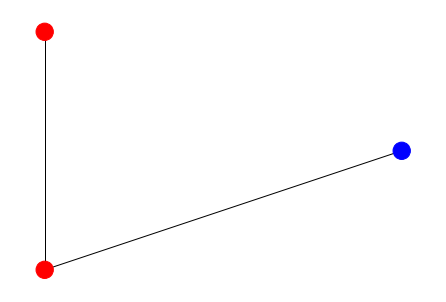

################ comm id: 22
Number of nodes: 3
Number of MLTargets: 0


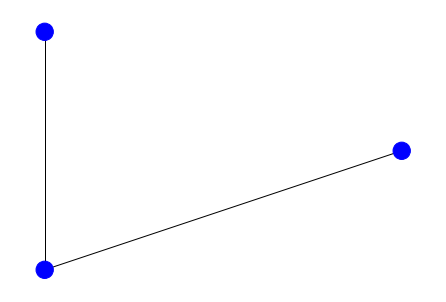

################ comm id: 23
Number of nodes: 4
Number of MLTargets: 3


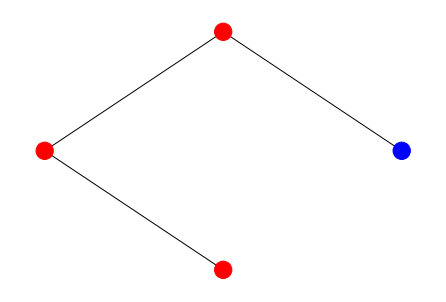

################ comm id: 24
Number of nodes: 3
Number of MLTargets: 0


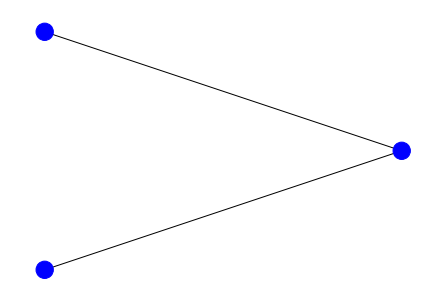

################ comm id: 25
Number of nodes: 3
Number of MLTargets: 0


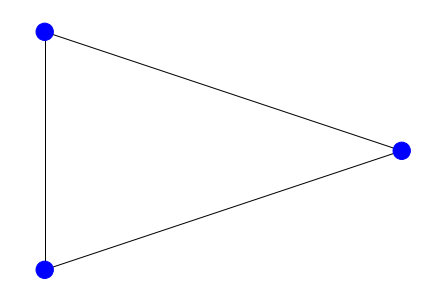

################ comm id: 26
Number of nodes: 3
Number of MLTargets: 0


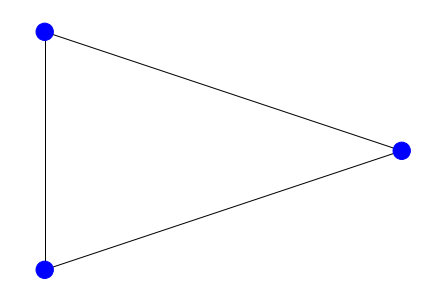

################ comm id: 27
Number of nodes: 0
Number of MLTargets: 0


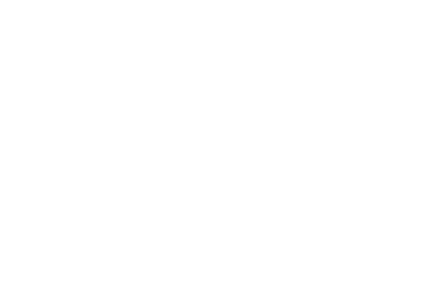

In [33]:
AnalyzeCommunityResults(nxgraph,louvainComms)

Number of nodes: 49
Number of MLTargets: 7


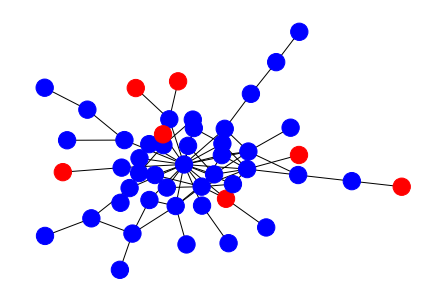

In [61]:
PrintCommunity(nxgraph,louvainComms[13],lambda g : nx.layout.kamada_kawai_layout(g,scale=1))

In [62]:
targetComm = louvainComms[13]


In [88]:
query = {}
for node in targetComm:
    query[node] = nxgraph.edges(node)
    pass
links = {}


for source in query.keys():
    links[source] = []
    for target in query[node]:
        links[source].append(target[1])
        pass
    pass

links


{782: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 998: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 2124: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 2272: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 2448: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 2776: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 3150: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 3653: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 4358: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 4572: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 4718: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 4939: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 5509: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 5726: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 9282: [782, 15994, 19222, 19754, 21358, 23665, 27140, 36023],
 10350: [782, 15994, 19222, 19754, 21358, 23665, 27140, 3

In [98]:
internalLinks = 0
externalLinks = 0
countedLinks = {}
degrees = {}
for source in links.keys():
    countedLinks[source] = []
    degrees[source] = [0,0]
    for target in links[source]:
        if target in countedLinks.keys():
            if source in countedLinks[target]:
                break
            pass
        if louvainPart.inSameSubset(source,target):
            internalLinks += 1
            degrees[source][0] += 1
            pass
        else:
            externalLinks += 1
            degrees[source][1] += 1
            pass
        countedLinks[source].append(target)
        pass
    pass

In [100]:
Nc = len(targetComm)
print("Internal Links: " + str(internalLinks))
print("ExternalLinks: " + str(externalLinks))
print("ILS: " + str(internalLinks/(Nc*(Nc-1))))
degrees.values()

Internal Links: 225
ExternalLinks: 135
ILS: 0.09566326530612244


dict_values([[5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [0, 0], [5, 3], [5, 3], [5, 3], [0, 0], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [0, 0], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [5, 3], [0, 0], [5, 3], [5, 3], [5, 3], [5, 3]])

In [132]:
def notP(step, t_patch):
    return step*(1/t_patch)
    pass

def TossCoin(notp: float):
    return  random.random()<= 1 - notp
    pass


def PerformStep(graph: nx.graph.Graph, source: int, p: float) -> list[int]:
    infected = []
    itr = nxgraph.neighbors(source)
    for target in itr:
        if  not graph.nodes[target]["infected"] and not graph.nodes[target]["removed"]:
            if TossCoin(p):
                graph.nodes[target]["infected"] = True
                infected.append(target)
            pass
        pass
    return infected


def SIR(graph: nx.graph.Graph,source : int, t_patch: int) -> dict[int,list[int]]:
    frontier = []
    step = 1
    steps = {}
    frontier.append(source)
    nx.set_node_attributes(nxgraph,False,"infected")
    nx.set_node_attributes(nxgraph,False,"removed")
    while len(frontier)>0:
        nextfrontier = []
        steps[step] = []
        while len(frontier)>0:
            newt = frontier.pop()
            nxgraph.nodes[newt]["removed"] = True
            stepResult = PerformStep(graph,newt,notP(step,t_patch))
            for node in stepResult:
                nextfrontier.append(node)
                pass
            pass
        for node in nextfrontier:
            steps[step].append(node)
            frontier.append(node)
            pass
        nextfrontier.clear()
        step += 1
    return steps


In [133]:
result = SIR(nxgraph,1,100)

Text(0.5, 0, 'Step')

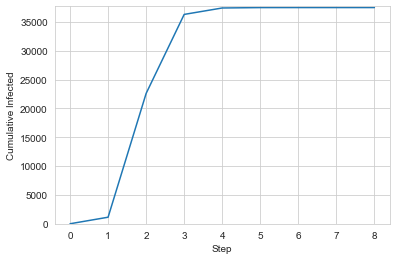

In [134]:
victimsPerStep = []
for step in result:
    victimsPerStep.append(len(result[step]))
    pass
ax = plt.gca()
ax.set_ylim([0,nxgraph.number_of_nodes()])
f = plt.plot(np.cumsum(victimsPerStep))
plt.ylabel("Cumulative Infected")
plt.xlabel("Step")


Text(0.5, 0, 'Step')

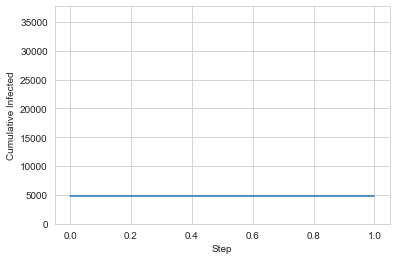

In [136]:
result = SIR(nxgraph,31890,2)
victimsPerStep = []
for step in result:
    victimsPerStep.append(len(result[step]))
    pass
ax = plt.gca()
ax.set_ylim([0,nxgraph.number_of_nodes()])
f = plt.plot(np.cumsum(victimsPerStep))
plt.ylabel("Cumulative Infected")
plt.xlabel("Step")


In [138]:
itr = nxgraph.neighbors(31890)
n = 0 
for node in itr:
    n += 1
    pass 
n

9458